In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pathlib
import random
import PIL
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
print('Imported')

Imported


## Import the dataset

/home/saksevul/T-MCC/calImages/img_validacion <class 'str'>
/home/saksevul/T-MCC/calImages/img_validacion <class 'pathlib.PosixPath'>
/home/saksevul/T-MCC/calImages/img_validacion/Di/6579_DiJet.jpeg
68 144


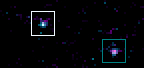

In [3]:
# directorio de datos
# data_dir = '/home/saksevul/T-MCC/calImages/seg_ResNet50'
data_dir = '/home/saksevul/T-MCC/calImages/img_validacion'
print(data_dir, type(data_dir))
data_dir = pathlib.Path(data_dir)
print(data_dir, type(data_dir))

# muestra de imagen de una de las clases
DiJ = list(data_dir.glob('Di/*'))
print(DiJ[7])
imgDi = PIL.Image.open(str(DiJ[7]))
print(imgDi.height, imgDi.width)
imgDi

## Split the data

In [27]:
# porcion de datos de validacion
p = 0.4

img_height,img_width=imgDi.height,imgDi.width
batch_size=16

# datos de entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=p,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(type(train_ds), '\n')

# datos de validacion
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=p,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(type(val_ds), '\n')

# clases de los datos utilizados
class_names = train_ds.class_names
img_classes = len(class_names)
print(class_names, type(class_names), img_classes, '\n')

print(list(train_ds.as_numpy_iterator()))

Found 6000 files belonging to 3 classes.
Using 3600 files for training.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 

Found 6000 files belonging to 3 classes.
Using 2400 files for validation.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> 

['Di', 'Multi', 'Random'] <class 'list'> 3 

[(array([[[[  0.,  66.,  69.],
         [  0.,  64.,  66.],
         [  0.,   1.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,  65.,  64.],
         [  0.,  65.,  69.],
         [  0.,   1.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   1.,   0.],
         [  0.,   0.,   0.],
         [  0.,   1.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
        

## Import the pre-trained model

In [4]:
resnet_model = Sequential()

# excluimos el top de la red para no tener problemas con la dimension de las imagenes
pretrained_model= tf.keras.applications.ResNet101(
                   include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg', 
                   classes=img_classes,
                   weights='imagenet')
# # no se entrenan las capas internas del modelo de transfer learning 
# for layer in pretrained_model.layers:
#         layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
# capas adicionales en la red, estas serán entrenadas
# resnet_model.add(Dense(512, activation='relu'))
# capa final con el número de clases
resnet_model.add(Dense(img_classes, activation='softmax'))

resnet_model.summary()

171450368/171446536 [==============================] - 24s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________


## Compile the model

In [5]:
# compilar el modelo
resnet_model.compile(optimizer=Adam(lr=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy',metrics.Precision(),metrics.Recall()])

# epocas de entrenamiento
epochs=32

# almacenar los valores del entrenamiento
history = resnet_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs)

Epoch 1/32
225/225 [==============================] - 522s 2s/step - loss: 1.5272 - accuracy: 0.4228 - precision: 0.4599 - recall: 0.1090 - val_loss: 113.3691 - val_accuracy: 0.3442 - val_precision: 0.3349 - val_recall: 0.2929
Epoch 2/32
225/225 [==============================] - 508s 2s/step - loss: 1.0618 - accuracy: 0.4808 - precision: 0.5926 - recall: 0.1658 - val_loss: 0.9766 - val_accuracy: 0.5108 - val_precision: 0.8792 - val_recall: 0.0971
Epoch 3/32
225/225 [==============================] - 515s 2s/step - loss: 0.9765 - accuracy: 0.5009 - precision: 0.6252 - recall: 0.2321 - val_loss: 1.5004 - val_accuracy: 0.4638 - val_precision: 0.5171 - val_recall: 0.3537
Epoch 4/32
225/225 [==============================] - 506s 2s/step - loss: 0.8686 - accuracy: 0.5666 - precision: 0.6607 - recall: 0.3119 - val_loss: 0.9733 - val_accuracy: 0.5658 - val_precision: 0.5884 - val_recall: 0.4938
Epoch 5/32
225/225 [==============================] - 493s 2s/step - loss: 0.7292 - accuracy: 0.68

## Evaluating the model

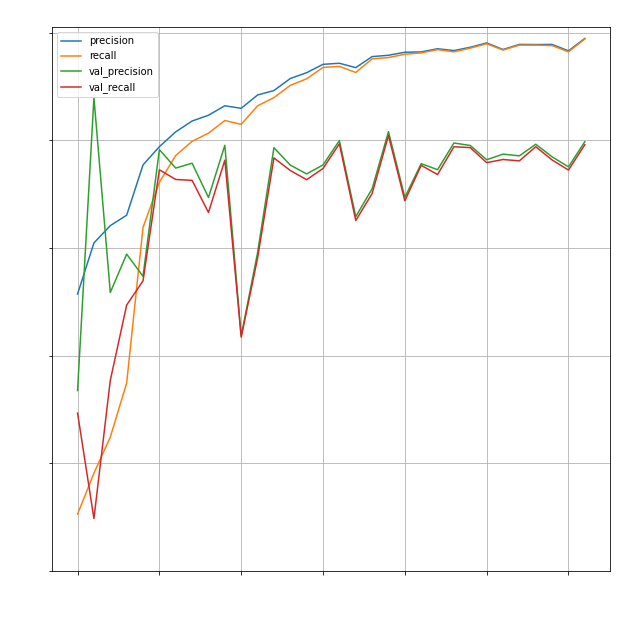

In [6]:
plt.figure(figsize=(10, 10))
fig1 = plt.gcf()
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.axis(ymin=0.0,ymax=1.01)
plt.xticks(fontsize=12,color="white")
plt.yticks(fontsize=12,color="white")
plt.grid()
plt.title('Model Metrics',fontsize=18,color="white")
plt.ylabel('Metrics',fontsize=15,color="white")
plt.xlabel('Epochs',fontsize=15,color="white")
plt.legend(['precision', 'recall', 'val_precision', 'val_recall'])
plt.show()
fig1.savefig('/home/saksevul/Pictures/MCC/Classifier/'+str(data_dir)[31:34]+'_rn101_'+'bs-'+str(batch_size)+'.png', format='png')

## Making predictions

In [7]:
for image, label in val_ds.take(1):
    valDS = image.numpy()
    valC = label.numpy()
    
valC = np.argmax(valC, axis=1)
clasesPred = resnet_model.predict_classes(valDS)
print(valC.shape, type(valC), clasesPred.shape, type(clasesPred))
print(clasesPred)
print(valC)
matrix = tf.math.confusion_matrix(valC, clasesPred)
print(matrix)


/home/saksevul/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(16,) <class 'numpy.ndarray'> (16,) <class 'numpy.ndarray'>
[2 2 1 2 0 1 2 0 2 0 1 2 0 2 2 1]
[2 2 1 2 0 1 2 0 2 0 2 2 2 2 2 1]
tf.Tensor(
[[3 0 0]
 [0 3 0]
 [1 1 8]], shape=(3, 3), dtype=int32)


In [28]:
# unbatch the data and convert it to list
train_ds = train_ds.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))
print('Converted to lists')

In [30]:
# print data
print(len(labels), type(labels))
print(len(images), type(images))
labels = np.array(labels)
images = np.array(images)
print(len(labels), type(labels), labels.shape, labels[0])
print(len(images), type(images), images.shape)

3600 <class 'numpy.ndarray'> [0. 1. 0.]
3600 <class 'numpy.ndarray'>
3600 <class 'numpy.ndarray'> (3600, 3) [0. 1. 0.]
3600 <class 'numpy.ndarray'> (3600, 68, 144, 3)


In [8]:
# directorio de datos
data_dir = '/home/saksevul/T-MCC/calImages/img_validacion'
data_dir = pathlib.Path(data_dir)

DiJ = list(data_dir.glob('Di/*'))
MultiJ = list(data_dir.glob('Multi/*'))
RandomJ = list(data_dir.glob('Random/*'))

u = random.randrange(0,900)
v = random.randrange(0,900)
w = random.randrange(0,900)

for i in [str(DiJ[u]), str(MultiJ[v]), str(RandomJ[w])]:
    print(i)
    image=np.expand_dims(cv2.resize(cv2.imread(i),(img_width,img_height)),axis=0)
    pred=resnet_model.predict(image)
    print(pred)
    print('  The predicted class is', class_names[np.argmax(pred)], '\n')

/home/saksevul/T-MCC/calImages/img_validacion/Di/8073_DiJet.jpeg
[[0.9376367  0.00562902 0.05673435]]
  The predicted class is Di 

/home/saksevul/T-MCC/calImages/img_validacion/Multi/8134_MultiJet.jpeg
[[5.2869022e-02 9.4678319e-01 3.4779904e-04]]
  The predicted class is Multi 

/home/saksevul/T-MCC/calImages/img_validacion/Random/8571_RandomJet.jpeg
[[2.3348792e-10 4.8015489e-09 1.0000000e+00]]
  The predicted class is Random 

